In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
# load the data


DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING )



In [4]:
print("Dataset size:", len(df))

Dataset size: 1599999


In [5]:
df.head(5)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
#column names
df.columns =["target", "ids", "date", "flag", "user", "text"]

In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
# global names
TARGET = 'target'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
#checking if there are empty columns
df.isnull().sum()


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

there aren't any empty columns.

# ***Text stats***

In [11]:
texts = df['text']

In [12]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


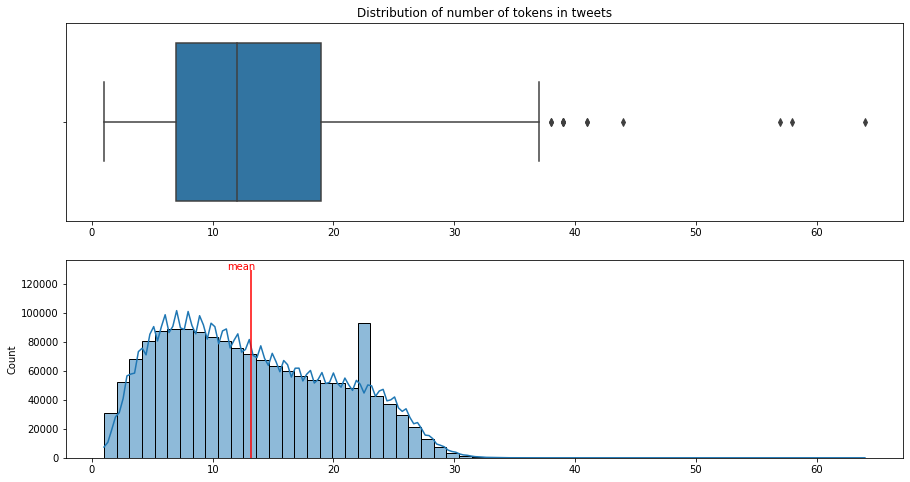

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=60, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 130000, color = 'r')
plt.annotate("mean", xy=(len_mean, 130000), xytext=(len_mean-2, 130000),
            color='r')
plt.show()

now we try to identify and exclude the outliers:

In [14]:
outliers = df['text'][np.array(text_lens) > 35]
print(len(outliers))

23


In [15]:
for idx in outliers.index:
    print(idx, 'Target', df[TARGET][idx])
    print(outliers[idx])
    print('///////////////////////////////'*4, '\n')

109663 Target 0
Who Am I Lying ! ? ! I Know , You Know , We All Know , My Ass Is Still Gonna Be Up . Hehe . My Ass Can't Sleep . I Need Help . For Real ! 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

336343 Target 0
I never get 2 c u as often as I like,I never get 2 hug in my every nite  but in my heart i know u r the one i luv n can't never let u go
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

374041 Target 0
I hate this , why does he have to be my step cousin  oh well , he keeps comin on to me ;) ha ha im in such a good mood , jesus , im tw ...
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

461027 Target 0
Is the saddest zornes ever thanks to the magic ( :  ( :  ( :  ( :  ( :  (  :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :   ...
//

As we can see these outliers seem to be fairly legitimate examples, the ones who don't are mainly because of punctuation exceses and that we can get rid off in the preprocessing step

# Target Analysis

In [16]:
#changing the names
sentiment_dict = {0:"negative", 4:"positive"}


target_balance = df[TARGET].value_counts().rename(index=sentiment_dict)




print(target_balance)

positive    800000
negative    799999
Name: target, dtype: int64


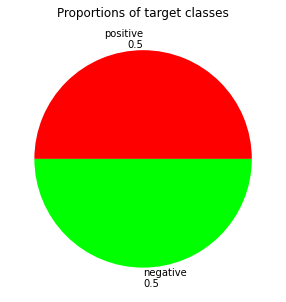

In [17]:

plt.figure(figsize=(5, 5))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index], 
        colors=['r', '#00FF00'])
plt.title('Proportions of target classes')
plt.show()

Target categories are equal size, so resampling is not required.

In [18]:
# top words
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = { 4: [],  #positive
                0: []}  #negative

pattern = re.compile('[^\w ]')
for text, t in zip(df['text'], df[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)


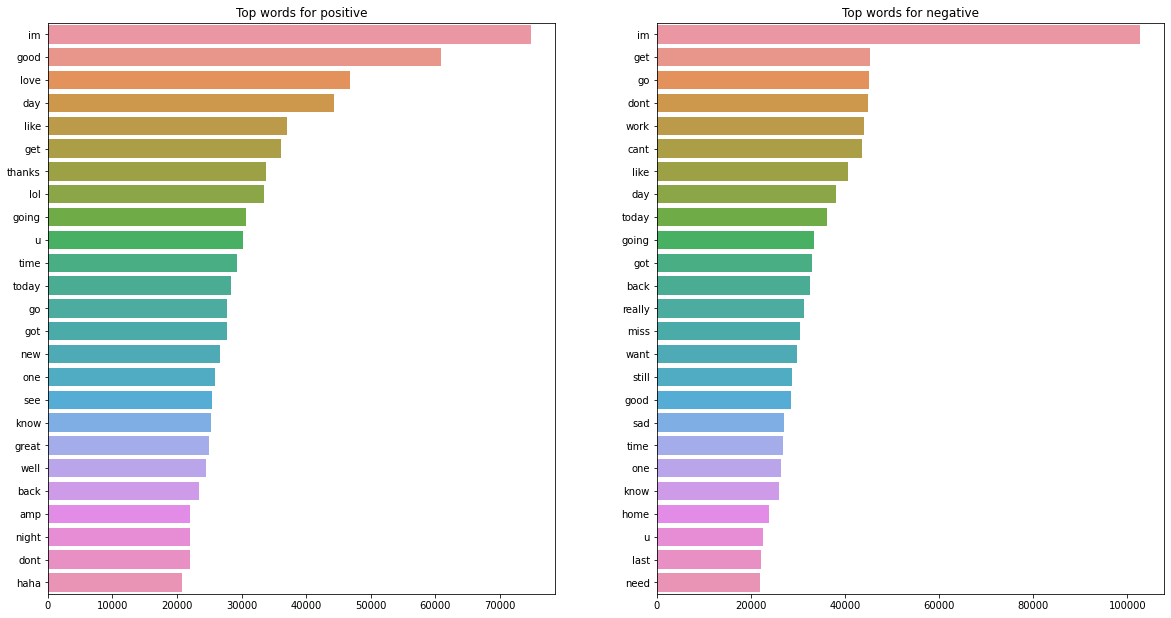

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20,10.5))
def changename(target):
    if target == 4:
        return ("positive")
    else:
        return ("negative")
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {changename(target)}')
plt.show()


#falta

# Preprocessing
# 

In [20]:
import nltk
from  nltk.stem import SnowballStemmer


stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TO_CLEAN = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [21]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TO_CLEAN, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [22]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 2s, sys: 222 ms, total: 1min 2s
Wall time: 1min 2s


# Split train and test


In [23]:
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1279999
TEST size: 320000


# Word2Vec

In [24]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 4.46 s, sys: 491 ms, total: 4.95 s
Wall time: 4.94 s


In [25]:
import gensim

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10



w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [26]:
w2v_model.build_vocab(documents)

In [27]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30298


In [28]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 20min 46s, sys: 5.23 s, total: 20min 51s
Wall time: 5min 49s


(263118511, 295311488)

In [29]:
w2v_model.wv.most_similar("love")

[('luv', 0.571240246295929),
 ('loves', 0.5490384697914124),
 ('adore', 0.5296568870544434),
 ('loved', 0.5095759034156799),
 ('lovee', 0.49639928340911865),
 ('amazing', 0.48601672053337097),
 ('looove', 0.47800683975219727),
 ('loveeeee', 0.46867063641548157),
 ('loooove', 0.46761980652809143),
 ('awesome', 0.4495372474193573)]

# Tokenize Text


In [30]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290442
CPU times: user 21.8 s, sys: 311 ms, total: 22.1 s
Wall time: 21.8 s


In [31]:
%%time
from keras.preprocessing.sequence import pad_sequences


SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


CPU times: user 28.4 s, sys: 817 ms, total: 29.2 s
Wall time: 29.2 s


# Label Encoder
# 

In [32]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [33]:
%%time
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))


CPU times: user 642 ms, sys: 4.01 ms, total: 646 ms
Wall time: 647 ms


In [34]:

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

labels = df_train.target.unique().tolist()
labels2 = df_test.target.unique().tolist()
labels.append(NEUTRAL)
labels2.append(NEUTRAL)
labels2

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [35]:
print(labels)
print(labels2)

['POSITIVE', 'NEGATIVE', 'NEUTRAL']
['NEGATIVE', 'POSITIVE', 'NEUTRAL']


In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1279999, 1)
y_test (320000, 1)


In [37]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1279999, 300)
y_train (1279999, 1)

x_test (320000, 300)
y_test (320000, 1)


In [38]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

# Embedding layer
# 

In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290442, 300)


In [40]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model
# 

In [41]:
from keras.models import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-10-11 11:01:11.264923: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87132600  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,293,101
Trainable params: 160,501
Non-trainable params: 87,132,600
_________________________________________________________________


# Compile model


In [42]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Callbacks

In [43]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

# Train

In [44]:
%%time

BATCH_SIZE = 1024
EPOCHS = 1             #they should be more but for a matter of time let's just do 1 epoch

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2022-10-11 11:01:17.399581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1125/1125 [==============================] - 8443s 7s/step - loss: 0.5150 - accuracy: 0.7436 - val_loss: 0.4697 - val_accuracy: 0.7777
CPU times: user 6h 43min 46s, sys: 18min 38s, total: 7h 2min 25s
Wall time: 2h 21min 30s


# Evaluate

In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 491s 2s/step - loss: 0.4685 - accuracy: 0.7775

ACCURACY: 0.7775281071662903
LOSS: 0.4684763252735138
CPU times: user 22min 46s, sys: 1min 37s, total: 24min 24s
Wall time: 8min 11s


# Predict

In [46]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [49]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [58]:
predict("I'm having a bad day")

{'label': 'NEGATIVE',
 'score': 0.07388639450073242,
 'elapsed_time': 0.21317768096923828}

In [60]:
predict("I hate the way he looks at me")

{'label': 'NEGATIVE',
 'score': 0.08675214648246765,
 'elapsed_time': 0.20446562767028809}

In [62]:
predict("Today I will finally make it")

{'label': 'POSITIVE',
 'score': 0.8054523468017578,
 'elapsed_time': 0.2108149528503418}

In [63]:
predict("Sometimes I don't know what I'm thinking")

{'label': 'NEUTRAL',
 'score': 0.5151408910751343,
 'elapsed_time': 0.201524019241333}

# Classification Report
# 

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

scores = model.predict(x_test, verbose=1, batch_size=8000)
y_test_1d = list(df_test.target)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

print(classification_report(y_test_1d, y_pred_1d))

40/40 [==============================] - 391s 10s/step
              precision    recall  f1-score   support

    NEGATIVE       0.77      0.79      0.78    159494
    POSITIVE       0.79      0.76      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# Accuracy Score

In [57]:
accuracy_score(y_test_1d, y_pred_1d)


0.777528125